# Common imports

In [1]:
%matplotlib inline
import os
import sys
import glob
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import scipy.ndimage
from random import *

# Provided functions
### Image loading and saving

In [2]:
def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

In [3]:
def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)

### Plot the height map

In [4]:
def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])


def display_output(albedo_image, height_map):
    fig = plt.figure()
    plt.imshow(albedo_image, cmap='gray')
    plt.axis('off')
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.view_init(20, 20)
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)

### Plot the surface norms. 

In [5]:
def plot_surface_normals(surface_normals):
    """
    surface_normals: h x w x 3 matrix.
    """
    fig = plt.figure()
    ax = plt.subplot(1, 3, 1)
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0])
    ax = plt.subplot(1, 3, 2)
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1])
    ax = plt.subplot(1, 3, 3)
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2])

# Your implementation

In [6]:
def preprocess(ambimage, imarray):
    processed_imarray = imarray
    processed_imarray = np.subtract(processed_imarray, ambimage[:,:,None])
    min_value = np.min(processed_imarray)
    processed_imarray = np.add(processed_imarray, abs(min_value)).astype('float')
    max_value = np.amax(processed_imarray)
    processed_imarray = np.divide(processed_imarray, max_value)
    print('done with preprocess')
    """
    preprocess the data: 
        1. subtract ambient_image from each image in imarray. done 
        2. make sure no pixel is less than zero. done 
        3. rescale values in imarray to be between 0 and 1. done 
    Inputs:
        ambimage: h x w
        imarray: h x w x N images
    Outputs:
        processed_imarray: h x w x N images
    """
    return processed_imarray

In [7]:
def photometric_stereo(imarray, light_dirs):
    h = imarray.shape[0]
    w = imarray.shape[1]
    N = imarray.shape[2]
    reshaped_imarray = np.transpose(np.reshape(imarray,(h*w,N))) # 64 rows of r*w image pixels 
    g = np.linalg.lstsq(light_dirs, reshaped_imarray)[0] # solve lin eq
    g_x = np.reshape(g[0], (h,w))
    g_y = np.reshape(g[1], (h,w))
    g_z = np.reshape(g[2], (h,w))
    surface_normals = np.dstack((g_x,g_y,g_z)) # stack so we have image of vectors
    albedo_image = np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            cur_pixel_norm = np.linalg.norm(surface_normals[i][j]) # get magnitude of vector
            albedo_image[i][j]= cur_pixel_norm # assign magnitude to albedo image slot
            surface_normals[i][j] /= cur_pixel_norm # divide by mag to get unit norm
    print('done with photometric stereo')
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
    Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3
    """
    return albedo_image, surface_normals

In [8]:
def column(matrix, i):
    return np.asarray([row[i] for row in matrix])

In [9]:
def columns_l(matrix, i):
    return np.asarray([row[:i] for row in matrix])

In [10]:
def columns_r(matrix, i):
    return np.asarray([row[i:] for row in matrix])

In [11]:
def get_surface(surface_normals, integration_method):
    h = surface_normals.shape[0]
    w = surface_normals.shape[1]
    N = surface_normals.shape[2]
    fx_mat = np.zeros((h, w))
    fy_mat = np.zeros((h, w))
    
    for x in range(h):
        for y in range(w):
            fx_mat[x][y] = np.divide(surface_normals[x][y][0], surface_normals[x][y][2]).astype('float')
            fy_mat[x][y] = np.divide(surface_normals[x][y][1], surface_normals[x][y][2]).astype('float')

    if integration_method == 'method1' or integration_method == 'average':
        # method 1: rows first, then cols 
        height_map_col_1 = np.cumsum(fy_mat, axis=0) # sum over all col
        height_map_row_1 = np.cumsum(fx_mat[0][:])
        height_map_row_1 = np.tile(height_map_row_1, (h, 1)) 
        height_map_1 = np.add(height_map_col_1, height_map_row_1)
    
    if integration_method == 'method2' or integration_method == 'average':
        # method 2: cols first, then rows
        height_map_row_2 = np.cumsum(fx_mat, axis=1) # sum over all rows 
        height_map_col_2 = np.cumsum(column(fy_mat, 0).transpose(), axis=0).transpose()
        height_map_col_2 = np.tile(height_map_col_2, (w, 1)).transpose()
        height_map_2 = np.add(height_map_col_2, height_map_row_2)
    
    if integration_method == 'average':
        # method 3: average of the first two methods
        height_map_3 = np.add(height_map_1, height_map_2)
        height_map_3 = np.divide(height_map_3, 2)
    
    if integration_method == 'random':
        # method 4: several random paths 
        height_map_4 = np.zeros((h, w))
        for i in range(0,100):
            r_index = randint(0, h-1)
            c_index = randint(0, w-1)
            height_map_row_41 = np.cumsum(fx_mat[r_index][:])
            height_map_row_41 = np.tile(height_map_row_41, (h, 1))   
            height_map_col_41_top = np.flip(fy_mat[:r_index][:], 0)
            height_map_col_41_top = np.cumsum(height_map_col_41_top, axis=0)
            height_map_col_41_top = np.flip(height_map_col_41_top, 0) 
            height_map_col_41_bottom = fy_mat[r_index:][:]
            height_map_col_41_bottom = np.cumsum(height_map_col_41_bottom, axis=0)
            height_map_col_41 = np.concatenate((height_map_col_41_top, height_map_col_41_bottom), axis=0)
            height_map_41 = np.add(height_map_row_41, height_map_col_41)

            height_map_col_42 = np.cumsum(column(fy_mat, c_index).transpose(), axis=0).transpose()
            height_map_col_42 = np.tile(height_map_col_42, (w, 1)).transpose()
            height_map_row_42_left = np.flip(np.cumsum(np.flip(columns_l(fx_mat,c_index), 1), axis=1), 1)
            height_map_row_42_right = np.cumsum(columns_r(fx_mat, c_index), axis=1)
            height_map_row_42 = np.concatenate((height_map_row_42_left, height_map_row_42_right), axis=1)
            height_map_42 = np.add(height_map_row_42, height_map_col_42)
            height_map_4 += height_map_42 + height_map_41
        height_map_4 = np.divide(height_map_4, 100)
    
    if(integration_method == 'method1'):
        print('method 1 chosen')
        height_map = height_map_1
    elif(integration_method == 'method2'):
        print('method 2 chosen')
        height_map = height_map_2
    elif(integration_method == 'average'):
        print('average chosen')
        height_map = height_map_3
    else:
        print('random chosen')
        height_map = height_map_4
    
    height_map = scipy.ndimage.filters.gaussian_filter(height_map, 5) # smooth height abnormalities

    """
    Inputs:
        surface_normals:h x w x 3
        integration_method: string in ['average', 'column', 'row', 'random']
    Outputs:
        height_map: h x w
    """
    print('done with height mapping')
    return height_map

# Main function

In [12]:
root_path = '../croppedyale/'
subject_name = 'yaleB02'
integration_method = 'random'
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                    64)

processed_imarray = preprocess(ambient_image, imarray)

albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                   light_dirs)

height_map = get_surface(surface_normals, integration_method)

if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

done with preprocess
done with photometric stereo
random chosen
done with height mapping


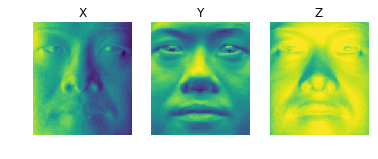

In [13]:
plot_surface_normals(surface_normals)

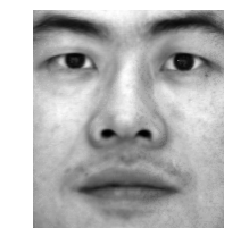

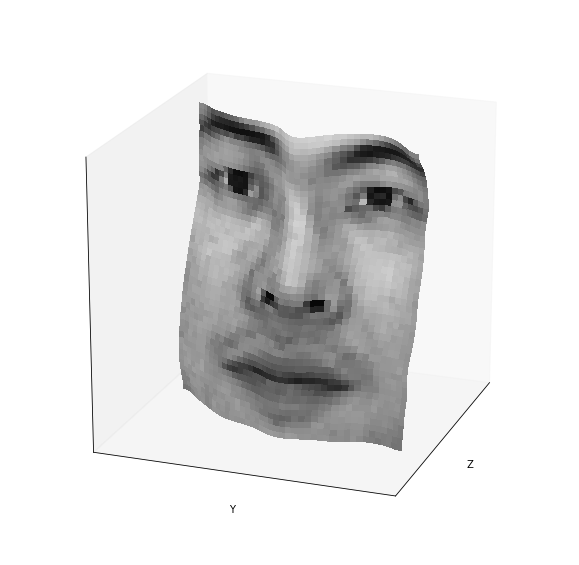

In [14]:
display_output(albedo_image, height_map)